<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_Computer_Vision/blob/main/YOLO_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Mount and Packages/Modules Importation**

In [ ]:
import os
import time
import copy

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, dump, ElementTree

import numpy as np
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

from collections import OrderedDict

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

import warnings
warnings.filterwarnings("ignore")

cuda


# **※ Dataset Preparation**

###**Face Mask Detection Dataset** -- *416 X 416 pixels RGB Color images* with 3 class labels  
1(With Mask, 완벽한 착용), 2(Without Mask, 미착용), 0(Improper Mask, 불완전 착용)

In [ ]:
class People_Dataset(Dataset):
    def __init__(self, root, imgs, transforms=None):
        self.root = root                                        # self.root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "Capstone Design", "datasets", "train/valid/test 中 1개")
        self.imgs = imgs                                        # 이미지 파일명 list
        self.img_path_list = []                                 # 이미지 파일 경로 list
        self.box_list = []                                      # Ground Truth B-Box list
        self.num_obj_list = []                                  # 모든 이미지의 Object 갯수 list
        self.label_list = []                                    # 모든 이미지 내의 Object Class Label list

        self.transforms = transforms
        self.max_obj_num = 0

        for i in tqdm(range(len(self.imgs)), desc = 'get data...'):
            img = Image.open(os.path.join(self.root, self.imgs[i])).convert("RGB")
            num_objs, boxes, labels = self._get_infos(i)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
            if num_objs != 0:
                
                if num_objs > self.max_obj_num:
                    self.max_obj_num = num_objs
                
                self.img_path_list.append(os.path.join(self.root, self.imgs[i]))
                self.num_obj_list.append(num_objs)
                self.box_list.append(boxes)
                self.label_list.append(labels)
        
    def __getitem__(self, idx):       # arg로 들어온 idx에 해당하는 이미지 불러오기
        img = Image.open(self.img_path_list[idx]).convert("RGB")
        img = transforms.ToTensor()(img)
        boxes = self.box_list[idx]
        num_objs = self.num_obj_list[idx]
        labels = self.label_list[idx]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        if num_objs != 1:
            area = torch.as_tensor(boxes[:, 2] * boxes[:, 3], dtype=torch.float32)
        else:
            area = torch.as_tensor(boxes[0, 2] * boxes[0, 3], dtype=torch.float32).unsqueeze(0)
     
        boxes = torch.cat((boxes, torch.zeros(self.max_obj_num - num_objs, boxes.size()[1])), dim = 0)                  # max_obj_num 만큼 tensor 크기 단일화를 위한 padding
        labels = torch.cat((labels, torch.zeros(self.max_obj_num - num_objs).type(torch.IntTensor) + 3), dim = 0)
        iscrowd = torch.cat((iscrowd, torch.zeros(self.max_obj_num - num_objs).type(torch.IntTensor) + 2), dim = 0)
        area = torch.cat((area, torch.zeros(self.max_obj_num - num_objs)), dim = 0)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["iscrowd"] = iscrowd 
        target["area"] = area
        
        return img, target              # return 튜플 => (img, target => boxes, labels, area, iscrowd)

    def __len__(self):
        return len(self.img_path_list)
    
    def _get_infos(self, idx):
        num_objs = 0
        boxes = []
        labels = []
        
        file_name = self.imgs[idx][:-4] + '.xml'
            
        with open(os.path.join(self.root, file_name)) as xml_file:
            doc = ET.parse(xml_file)
            annots = doc.getroot()

            for thing in annots.iter("object"):
                xmin = int(thing.find("bndbox").findtext("xmin"))
                xmax = int(thing.find("bndbox").findtext("xmax"))
                ymin = int(thing.find("bndbox").findtext("ymin"))
                ymax = int(thing.find("bndbox").findtext("ymax"))

                if xmax > xmin and ymax > ymin and xmax <= 416 and xmin >= 0 and ymax <= 416 and ymin >= 0:
                    num_objs += 1                                           # 해당 이미지의 object 갯수 1 증가

                    cx = ((xmin + xmax) / 2) / 416                          # Original Image size = 256 X 256 => convert to YOLO B-Box
                    cy = ((ymin + ymax) / 2) / 416
                    w = (xmax - xmin) / 416
                    h = (ymax - ymin) / 416

                    boxes.append([cx, cy, w, h])                            # 현재 확인하고 object의 bbox 추가

                    label = thing.findtext("name")
                    if label == "mask":
                        label = 1
                    elif label == "no-mask":
                        label = 2
                    elif label == "improper_mask":
                        label = 0
                    labels.append(label)                                    # 현재 확인하고 있는 object의 label 추가
        
        return num_objs, boxes, labels

In [ ]:
train_root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data", "mask_train")  ## Train Image data 경로 설정
train_list = list(os.listdir(train_root))

train_imgs = []
train_annots = []
for a in range(len(train_list)):
    if train_list[a][-4:] == ".jpg":
        train_imgs.append(train_list[a])
        continue
    
    if train_list[a][-4:] == ".xml":
        train_annots.append(train_list[a])


valid_root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data", "mask_valid")  ## Valid Image data 경로 설정
valid_list = list(os.listdir(valid_root))

valid_imgs = []
valid_annots = []
for a in range(len(valid_list)):
    if valid_list[a][-4:] == ".jpg":
        valid_imgs.append(valid_list[a])
        continue
    
    if valid_list[a][-4:] == ".xml":
        valid_annots.append(valid_list[a])


test_root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data", "mask_test")  ## Test Image data 경로 설정
test_list = list(os.listdir(test_root))

test_imgs = []
test_annots = []
for a in range(len(test_list)):
    if test_list[a][-4:] == ".jpg":
        test_imgs.append(test_list[a])
        continue
    
    if test_list[a][-4:] == ".xml":
        test_annots.append(test_list[a])

print(len(train_imgs))
print(len(valid_imgs))
print(len(test_imgs))

1682
452
249


### **Train/Valid/Test Dataset Class Definition**

In [ ]:
train_data = People_Dataset(root=train_root, imgs=train_imgs, transforms=None)
valid_data = People_Dataset(root=valid_root, imgs=valid_imgs, transforms=None)
test_data = People_Dataset(root=test_root, imgs=test_imgs, transforms=None)
print()

train_img, train_target = train_data[0]
print(f"# of Train Dataset = {len(train_data)}")
print(f"Sample Size of Train Dataset = {train_img.shape}")
print(f"Sample Train Dataset Target\n{train_target}")
print()

valid_img, valid_target = valid_data[0]
print(f"# of Valid Dataset = {len(valid_data)}")
print(f"Sample Size of Valid Dataset = {valid_img.shape}")
print(f"Sample Valid Dataset Target\n{valid_target}")
print()

print(f"Test Dataset Size = {len(test_data)}")

get data...: 100%|███████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 855.95it/s]


# of Train Dataset = 1455
Sample Size of Train Dataset = torch.Size([3, 416, 416])
Sample Train Dataset Target
{'boxes': tensor([[0.5685, 0.4026, 0.5505, 0.7380],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

### **Ground Truth Checking by Sample Visualization**

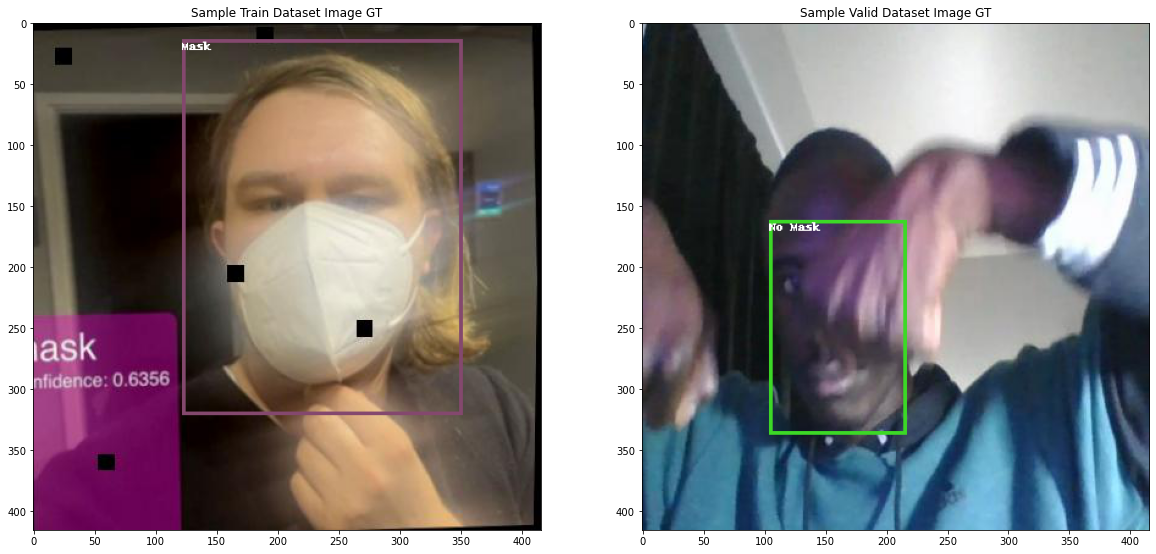

In [ ]:
colors = np.random.randint(0, 255, size=(3, 3), dtype="uint8")

def get_coord(box):

    cx, cy, w, h = box[0] * 416, box[1] * 416, box[2]* 416, box[3]* 416
    xmin = int(cx - w/2)
    ymin = int(cy - h/2)
    xmax = int(cx + w/2)
    ymax = int(cy + h/2)

    return xmin, ymin, xmax, ymax
    

def show_img_bbox(img, target):
    if torch.is_tensor(img):
        img = transforms.functional.to_pil_image(img)

    if torch.is_tensor(target):
        target = target.numpy()
    
    width, height = img.size
    draw = ImageDraw.Draw(img)

    labels = target["labels"]
    boxes = target["boxes"]
    for label, box in zip(labels, boxes):
        if label == 0:
            name = "Improper Mask"
        elif label == 1:
            name = "Mask"
        elif label == 2:
            name = "No Mask"
        
        if label <= 2:
            xmin, ymin, xmax, ymax = get_coord(box)

            color = [int(c) for c in colors[label]]

            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=tuple(color), width=3)
            draw.text((xmin, ymin), name, fill=(255, 255, 255, 0))
    
    plt.imshow(np.array(img))

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title("Sample Train Dataset Image GT")
show_img_bbox(train_img, train_target)
plt.subplot(1, 2, 2)
plt.title("Sample Valid Dataset Image GT")
show_img_bbox(valid_img, valid_target)

### **Train / Valid / Test DataLoader Generation**

In [ ]:
def collate_fn(batch):
    image_list = []
    boxes_list = []
    labels_list = []
    iscrowd_list = []
    area_list = []
    
    for image, target in batch :

        boxes = target["boxes"]
        labels = target["labels"]
        iscrowd = target["iscrowd"]
        area = target["area"]
        
        image_list.append(image)
        boxes_list.append(boxes)
        labels_list.append(labels)
        iscrowd_list.append(iscrowd)
        area_list.append(area)
    
    image_list = torch.stack(image_list, 0)
    boxes_list = torch.stack(boxes_list, 0)
    labels_list = torch.stack(labels_list, 0)
    iscrowd_list = torch.stack(iscrowd_list, 0)
    area_list = torch.stack(area_list, 0)
    
    target_list = {}
    target_list["boxes"] = boxes_list
    target_list["labels"] = labels_list
    target_list["iscrowd"] = iscrowd_list
    target_list["area"] = area_list
        
    return image_list, target_list

        
train_loader = DataLoader(train_data, batch_size=15, collate_fn=collate_fn, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=8, collate_fn=collate_fn, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=collate_fn, shuffle=False, drop_last=False)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

97
51
224


# <font color="#FF0000"> **※ Advanced YOLO v3 Model and Actuator Definition** </font>

### <font color="#FF0000"> **① Architecture of Advanced YOLO v3 Model with Residual Block, FPN, Feature Extraction** </font>

In [ ]:
## Basic Covn Block in YOLO v3 Model
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, input):
        return self.conv_block(input)


## Residual Block with Full Pre-Activation in YOLO v3 Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_2 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm_1 = nn.BatchNorm2d(in_channels)
        self.batchnorm_2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, input):                                       # Architecture of Full Pre-Activation
        temp1 = self.batchnorm_1(input)                             # ① Batch-Normalization first
        temp2 = self.relu(temp1)                                    # ② ReLU Activation second
        temp3 = self.conv_1(temp2)                                  # ③ Pass Convolutional Layer next, and iterate twice

        temp4 = self.batchnorm_2(temp3)
        temp5 = self.relu(temp4)
        out_temp = self.conv_2(temp5)
        
        output = input + out_temp

        return output


## FPN For Top Down Method in YOLO v3 Model
class FPNTopDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.topdown_block = nn.Sequential(
            BasicConv(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            BasicConv(out_channels, out_channels * 2, kernel_size=3, stride=1, padding=1),
            BasicConv(out_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
            BasicConv(out_channels, out_channels * 2, kernel_size=3, stride=1, padding=1),
            BasicConv(out_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
        )
    
    def forward(self, input):
        return self.topdown_block(input)


## 3-Scale Feature Extraction in YOLO v3 Model
class YOLOExt(nn.Module):
    def __init__(self, channels, anchors, n_class=3, img_size=416):
        super().__init__()

        self.anchors = anchors                                                      # small 3개 + medium 3개 + large 3개
        self.n_anchor = len(anchors)
        self.n_class = n_class
        self.img_size = img_size
        self.grid_size = 0

        self.conv_block = nn.Sequential(
            BasicConv(channels, channels * 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(channels * 2, 24, 1, stride=1, padding=0)                     # 24 = 3(# of scale) X (4=bbox coordinates + 1=conf score + 3=# of class)
        )
    
    def forward(self, input):
        input = self.conv_block(input)
        
        batch_size = input.size(0)
        grid_size = input.size(2)           # 13 or 26 or 52
        device = input.device
        
        pred = input.view(batch_size, self.n_anchor, self.n_class + 5, grid_size, grid_size)    # [batch_size, 3, 8(3+4+1), grid_size, grid_size]
        pred = pred.permute(0, 1, 3, 4, 2).contiguous()                                         # [batch_size, 3, grid_size, grid_size, 8(4+1+3)]로 변환
        obj_score = torch.sigmoid(pred[..., 4])         # object conf score
        pred_class = torch.sigmoid(pred[..., 5:])       # class prediction

        if grid_size != self.grid_size:
            self.compute_grid_cells(grid_size)
        
        pred_boxes = self.compute_pred_bbox(pred)
        output = torch.cat((pred_boxes.view(batch_size, -1, 4), obj_score.view(batch_size, -1, 1), pred_class.view(batch_size, -1, self.n_class)), -1)

        return output

    def compute_grid_cells(self, grid_size):
        self.grid_size = grid_size
        self.stride = self.img_size / self.grid_size            # stride = 1개의 행/열 당 몇개의 Grid Cell이 존재하는지
        
        self.grid_x = torch.arange(grid_size, device="cuda").repeat(1, 1, grid_size, 1).type(torch.float32)
        self.grid_y = torch.arange(grid_size, device="cuda").repeat(1, 1, grid_size, 1).transpose(3, 2).type(torch.float32)

        scaled_anchors = [(aw / self.stride, ah / self.stride) for aw, ah in self.anchors]      # anchor 가로/세로를 grid size와 동일하게 맞춤(정규화)
        self.scaled_anchors = torch.tensor(scaled_anchors, device="cuda")

        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.n_anchor, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.n_anchor, 1, 1))
    
    def compute_pred_bbox(self, pred):
        device = pred.device

        cx = torch.sigmoid(pred[..., 0])
        cy = torch.sigmoid(pred[..., 1])
        w = pred[..., 2]
        h = pred[..., 3]
        
        pred_boxes = torch.zeros_like(pred[..., :4]).to(device)
        pred_boxes[..., 0] = cx.data + self.grid_x
        pred_boxes[..., 1] = cy.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        return pred_boxes * self.stride


## DarkNet-53 in YOLO v3 Model
class DarkNet(nn.Module):
    def __init__(self, anchors, blocks=[1, 2, 8, 8, 4], n_class=3):
        super().__init__()

        self.conv_block = BasicConv(3, 32, 3, stride=1, padding=1)

        self.res_block_1 = self._make_residual(64, blocks[0])
        self.res_block_2 = self._make_residual(128, blocks[1])
        self.res_block_3 = self._make_residual(256, blocks[2])              # ① Top-Down for 52 X 52 Feature map
        self.res_block_4 = self._make_residual(512, blocks[3])              # ② Top-Down for 26 X 26 Feature map
        self.res_block_5 = self._make_residual(1024, blocks[4])             # ③ Top-Down for 13 X 13 Feature map

        self.fpn_topdown_1 = FPNTopDown(1024, 512)
        self.fpn_topdown_2 = FPNTopDown(768, 256)
        self.fpn_topdown_3 = FPNTopDown(384, 128)

        self.before_upsample_1 = BasicConv(512, 256, 1, stride=1, padding=0)
        self.before_upsample_2 = BasicConv(256, 128, 1, stride=1, padding=0)
        
        self.yolo_large = YOLOExt(512, anchors=anchors[2])                  # 이후에 1024 X 13 X 13
        self.yolo_medium = YOLOExt(256, anchors=anchors[1])                 # 이후에 512 X 26 X 26
        self.yolo_small = YOLOExt(128, anchors=anchors[0])                  # 이후에 256 X 52 X 52

        self.upsample = nn.Upsample(scale_factor=2)

    def _make_residual(self, channels, num_blocks):
        res_blocks = []
        res_blocks.append(BasicConv(channels // 2, channels, 3, stride=2, padding=1))

        for i in range(num_blocks):
            res_blocks.append(ResidualBlock(channels, channels // 2))
        
        return nn.Sequential(*res_blocks)
    
    def forward(self, input):
        input = self.conv_block(input)

        c1 = self.res_block_1(input)
        c2 = self.res_block_2(c1)
        c3 = self.res_block_3(c2)
        c4 = self.res_block_4(c3)
        c5 = self.res_block_5(c4)
        
        p5 = self.fpn_topdown_1(c5)
        p4 = self.fpn_topdown_2(torch.cat((self.upsample(self.before_upsample_1(p5)), c4), 1))      # channel dimension 기준으로 concetenation
        p3 = self.fpn_topdown_3(torch.cat((self.upsample(self.before_upsample_2(p4)), c3), 1))      # channel dimension 기준으로 concetenation
        
        large_feature = self.yolo_large(p5)
        medium_feature = self.yolo_medium(p4)
        small_feature = self.yolo_small(p3)

        return torch.cat((large_feature, medium_feature, small_feature), 1), [large_feature, medium_feature, small_feature]


anchors = [[(10, 13), (16, 30), (33, 23)], [(30, 61), (62, 45), (59, 119)], [(116, 90), (156, 198), (373, 326)]]
sample = torch.randn(1, 3, 416, 416).to(device)
with torch.no_grad():
    yolov3 = DarkNet(anchors).to(device)
    output_cat, output = yolov3(sample)
    print("Output Concetenation Size :", output_cat.size())
    print(output[0].size(), output[1].size(), output[2].size())

Output Concetenation Size : torch.Size([1, 10647, 8])
torch.Size([1, 507, 8]) torch.Size([1, 2028, 8]) torch.Size([1, 8112, 8])


### <font color="#FF0000"> **② Actuator(Trainer/Tester) Construction for Advanced YOLO v3** </font>

In [ ]:
class YOLOv3_Actuator(nn.Module):
    def __init__(self, root, train_loader, valid_loader, test_loader, model, opt="adam", lr=0.001, has_scheduler=False, device="cuda"):
        super().__init__()

        self.root = root                                    # Best Epoch Model 저장할 디렉토리 full path 

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.model = model
        self.mse_loss = nn.MSELoss(reduction="sum")         # 논문과의 차이점 : SSE 대신 MSE 적용
        self.bce_loss = nn.BCELoss(reduction="sum")
        
        self.scaled_anchors = [
            self.model.yolo_large.scaled_anchors,
            self.model.yolo_medium.scaled_anchors,
            self.model.yolo_small.scaled_anchors,
        ]

        self.param_loss = {
            "scaled_anchors" : self.scaled_anchors,
            "ignore_thres" : 0.5,
            "n_yolo" : 3,                                   # scaled feature map 갯수 = 3
            "n_anchor" : 3,                                 # 각각의 scaled feature map당 anchor box의 갯수 = 3
            "obj_scale" : 5,
            "noobj_scale" : 0.5,
        }

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()
        
        self.device = device
    
    def _batch_loss(self, output, targets, param_loss, is_train=False):
        ignore_thres = param_loss["ignore_thres"]
        scaled_anchors = param_loss["scaled_anchors"]
        n_yolo = param_loss["n_yolo"]
        n_anchor = param_loss["n_anchor"]
        obj_scale = param_loss["obj_scale"]
        noobj_scale = param_loss["noobj_scale"]

        loss = 0.0

        for yolo_id in range(n_yolo):                   # large(13 X 13), medium(26 X 26), small(52 X 52) 순서로 대해 반복
            yolo_out = output[yolo_id]                  # yolo_out = batch, num_boxes, coord(4) + 1(conf) + 3(class)
            batch_size, n_box, _ = yolo_out.shape
            grid_size = int(np.sqrt(n_box / n_anchor))

            yolo_out = yolo_out.view(batch_size, n_anchor, grid_size, grid_size, -1)
            pred_boxes = yolo_out[:, :, :, :, :4]
            pred_conf = yolo_out[:, :, :, :, 4]
            pred_class_prob = yolo_out[:, :, :, :, 5:]
            x, y, w, h = self._change_bbox(pred_boxes, scaled_anchors[yolo_id])         # pred box에 대해 grid cell 내에서의 x, y, w, h로 변환

            yolo_targets = self._yolo_targets({
                "pred_boxes" : pred_boxes,
                "pred_class_prob" : pred_class_prob,
                "targets" : targets,
                "anchors" : scaled_anchors[yolo_id],
                "ignore_thres" : ignore_thres
            })

            obj_mask = yolo_targets["obj_mask"]
            noobj_mask = yolo_targets["noobj_mask"]
            tx = yolo_targets["tx"]
            ty = yolo_targets["ty"]
            tw = yolo_targets["tw"]
            th = yolo_targets["th"]
            tclass = yolo_targets["tclass"]
            tconf = yolo_targets["tconf"]

            x_loss = self.mse_loss(x[obj_mask].to(device), tx[obj_mask].to(device))         # 예측 Bbox Coordinates와 Anchor Box 간의 MSE Loss 계산
            y_loss = self.mse_loss(y[obj_mask].to(device), ty[obj_mask].to(device))
            w_loss = self.mse_loss(w[obj_mask].to(device), tw[obj_mask].to(device))
            h_loss = self.mse_loss(h[obj_mask].to(device), th[obj_mask].to(device))

            conf_obj_loss = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])             # object confidence score에 대해 예측 & 실제와의 BCE Loss 계산
            conf_noobj_loss = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            conf_loss = (obj_scale * conf_obj_loss) + (noobj_scale * conf_noobj_loss)
            
            class_prob_loss = self.bce_loss(pred_class_prob[obj_mask], tclass[obj_mask])    # object가 특정 class label일 확률에 대한 예측 & 실제와의 BCE Loss 계산
            
            loss += x_loss + y_loss + w_loss + h_loss + conf_loss + class_prob_loss         # 모든 Loss 총합 계산
        
        loss = loss / x.size()[0]
        
        if (self.optimizer is not None) and (is_train == True) :
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        return loss.item()
    
    def _change_bbox(self, box, anchors):                       # 전체 이미지의 x, y, w, h => Grid Cell 내의 x, y, w, h로 변환
        x = box[:, :, :, :, 0]
        y = box[:, :, :, :, 1]
        w = box[:, :, :, :, 2]
        h = box[:, :, :, :, 3]

        anchor_w = anchors[:, 0].view((1, 3, 1, 1))
        anchor_h = anchors[:, 1].view((1, 3, 1, 1))

        x -= x.floor()                                          # 전체 이미지에서의 x좌표 => 특정 grid cell 내에서의 x좌표로 변환
        y -= y.floor()                                          # 전체 이미지에서의 y좌표 => 특정 grid cell 내에서의 y좌표로 변환
        w = torch.log(w / anchor_w + 1e-16)                     # 예측 bbox의 width / anchor box의 width로 변환
        h = torch.log(h / anchor_h + 1e-16)                     # 예측 bbox의 height / anchor box의 height로 변환

        return x, y, w, h

    def _yolo_targets(self, arguments):
        pred_boxes = arguments["pred_boxes"]
        pred_class_prob = arguments["pred_class_prob"]
        target = arguments["targets"]
        anchors = arguments["anchors"]
        ignore_thres = arguments["ignore_thres"]
        
        batch_size = pred_boxes.size(0)
        n_anchor = pred_boxes.size(1)
        grid_size = pred_boxes.size(2)
        n_class = pred_class_prob.size(-1)

        # target 분해
        boxes = target["boxes"]         # [batch_size, 100, 4]
        labels = target["labels"]       # [batch_size, 100]
        iscrowd = target["iscrowd"]     # [batch_size, 100]
        area = target["area"]           # [batch_size, 100]

        sizeT = batch_size, n_anchor, grid_size, grid_size                  # (batch_size, anchor box 갯수, grid_size, grid_sze) 튜플화 
        obj_mask = torch.zeros(sizeT, device="cuda", dtype=torch.uint8)
        noobj_mask = torch.ones(sizeT, device="cuda", dtype=torch.uint8)
        tx = torch.zeros(sizeT, device="cuda", dtype=torch.float32)
        ty = torch.zeros(sizeT, device="cuda", dtype=torch.float32)
        tw = torch.zeros(sizeT, device="cuda", dtype=torch.float32)
        th = torch.zeros(sizeT, device="cuda", dtype=torch.float32)

        sizeT = batch_size, n_anchor, grid_size, grid_size, n_class
        tclass = torch.zeros(sizeT, device="cuda", dtype=torch.float32)

        target_boxes = boxes * grid_size            # [batch_size, 100, 4] * grid_size
        
        
        # 각 pred_bbox의 답지를 구하는 과정
        for i in range(target_boxes.size()[0]):     # Iteration의 각각은 batch_size, 원래는 iteration 없이 한번에 처리
            
            valid_val_index = (labels[i] < 3).nonzero(as_tuple=True)[0]
            
            boxes = target_boxes[i, valid_val_index, :]     # i번째 batch의 valid_val_index에 해당하는 object의 bbox 좌표

            t_xy = boxes[:, :2]
            t_wh = boxes[:, 2:]
            t_x, t_y = t_xy.t()     # bbox x좌표값들의 tensor
            t_w, t_h = t_wh.t()     # bbox y좌표값들의 tensor
            
            grid_i, grid_j = t_xy.long().t()
            
            iou_anchors = [self._get_IoU_WH(anchor, t_wh) for anchor in anchors]        # Anchor와 Ground Truth간의 IoU 계산
            iou_anchors = torch.stack(iou_anchors)
            best_iou_anchor, best_anchor_id = iou_anchors.max(0)                        # iou_anchors의 열을 기준으로 (최댓값, 최댓값의 index) return
            
            target_labels = labels[i, valid_val_index].long()
            obj_mask[i, best_anchor_id, grid_j, grid_i] = 1                             # Object가 있는 곳에 대해 IoU가 가장 높은 Anchor를 Responsible
            noobj_mask[i, best_anchor_id, grid_j, grid_i] = 0                           # Object가 없는 곳에 대해 IoU가 가장 높은 Anchor를 Non-Responsible

            for id, iou_anchor in enumerate(iou_anchors.t()):
                noobj_mask[i, iou_anchor > ignore_thres, grid_j[id], grid_i[id]] = 0
        
            tx[i, best_anchor_id, grid_j, grid_i] = t_x - t_x.float()
            ty[i, best_anchor_id, grid_j, grid_i] = t_y - t_y.float()

            anchor_w = anchors[best_anchor_id][:, 0]
            tw[i, best_anchor_id, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)
            anchor_h = anchors[best_anchor_id][:, 1]
            th[i, best_anchor_id, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)

            tclass[i, best_anchor_id, grid_j, grid_i, target_labels] = 1
            
        output = {
            "obj_mask" : obj_mask,
            "noobj_mask" : noobj_mask,
            "tx" : tx,
            "ty" : ty,
            "tw" : tw,
            "th" : th,
            "tclass" : tclass[:, :, :, :, :],                  # tclass[:, :, :, :, :-1]
            "tconf" : obj_mask.float(),
        }

        return output
    
    def _get_IoU_WH(self, wh1, wh2):               # Anchor와 Ground Truth간의 IoU 계산
        wh2 = wh2.t()
        w1, h1 = wh1[0], wh1[1]
        w2, h2 = wh2[0], wh2[1]

        area_of_intersection = torch.min(w1, w2) * torch.min(h1, h2)
        area_of_union = (w1 * h1 + 1e-16) + (w2 * h2) - area_of_intersection

        return area_of_intersection / area_of_union

    def _get_optimizer(self, opt, lr=0.001):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=self.optimizer, mode="min", factor=0.5, patience=20, verbose=1)
    
    def _get_current_lr(self):
        for param_group in self.optimizer.param_groups:
            return param_group["lr"]

    def train_and_valid(self, max_epochs=10, disp_epochs=1):
        print("========== Train and Valid Start ==========")
        start_time = time.time()

        history = {"Train Loss" : [], "Valid Loss" : []}
        best_epoch = 0
        best_model = copy.deepcopy(self.model.state_dict())
        best_loss = float("inf")

        for epoch in tqdm(range(max_epochs), desc ='Train and Valid...'):
            current_lr = self._get_current_lr()

            train_loss = self._train_epoch()
            valid_loss = self._valid_epoch()

            history["Train Loss"].append(train_loss)
            history["Valid Loss"].append(valid_loss)

            if valid_loss < best_loss:
                best_epoch = epoch + 1
                best_loss = valid_loss
                best_model = copy.deepcopy(self.model.state_dict())
                print("Best YOLOv3 Model is Updated")

            if self.has_scheduler:
                self.scheduler.step(valid_loss)
            
            if epoch % disp_epochs == 0:
                print(f"{epoch+1}/{max_epochs} Epoch ==> LR : {current_lr}, Train Loss : {train_loss:>6f}, Valid Loss : {valid_loss:>6f}, Time : {time.time() - start_time:>3f}")
        
        best_name = "YOLOv3 Best of " + str(best_epoch) + "Epoch.pth"
        torch.save(self.model.state_dict(), os.path.join(self.root, best_name))
        self.plot_history(history)
    
    def _train_epoch(self):
        train_epoch_loss = 0
        self.model.train()

        for (x, y) in self.train_loader:
            x = x.to(self.device)
            
            y["boxes"] = y["boxes"].to(self.device)
            y["labels"] = y["labels"].to(self.device)
            y["iscrowd"] = y["iscrowd"].to(self.device)
            y["area"] = y["area"].to(self.device)
            
            _, output = self.model(x)
            
            temp_loss = self._batch_loss(output, y, self.param_loss, is_train=True)
            train_epoch_loss += temp_loss
        
        train_epoch_loss /= len(self.train_loader)
        return train_epoch_loss
    
    def _valid_epoch(self):
        valid_epoch_loss = 0
        self.model.eval()

        for (x, y) in self.valid_loader:
            x = x.to(self.device)
            
            y["boxes"] = y["boxes"].to(self.device)
            y["labels"] = y["labels"].to(self.device)
            y["iscrowd"] = y["iscrowd"].to(self.device)
            y["area"] = y["area"].to(self.device)
            
            _, output = self.model(x)

            temp_loss = self._batch_loss(output, y, self.param_loss, is_train=False)
            valid_epoch_loss += temp_loss
        
        valid_epoch_loss /= len(self.valid_loader)
        return valid_epoch_loss
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["Train Loss"], color="red", label="Train Loss")
        plt.plot(history["Valid Loss"], color="orange", label="Valid Loss")
        plt.title("Loss of Object Detection")
        plt.legend()

        fig.show()
    
    def test(self):
        print("========== Test Start ==========")
        start_time = time.time()

        test_loss = 0
        self.model.eval()

        for (x, y) in self.test_loader:
            x = x.to(self.device)
            
            y["boxes"] = y["boxes"].to(self.device)
            y["labels"] = y["labels"].to(self.device)
            y["iscrowd"] = y["iscrowd"].to(self.device)
            y["area"] = y["area"].to(self.device)
            _, output = self.model(x)

            temp_loss = self._batch_loss(output, y, self.param_loss)
            test_loss += temp_loss
        
        test_loss /= len(self.test_loader)
        print(f"Test Loss : {test_loss:>6f}, Time : {time.time() - start_time:>3f}")

# <font color="#FFBB00"> **※ Training / Validating / Testing** </font>

========== Train Start ==========


train...:   3%|██▍                                                                       | 1/30 [00:55<27:02, 55.95s/it]

Best YOLOv3 Model is Updated
1/30 Epoch ==> LR : 0.001, Train Loss : 627.404685, Valid Loss : 358.804050, Time : 55.974360


train...:   7%|████▉                                                                     | 2/30 [01:52<26:09, 56.06s/it]

Best YOLOv3 Model is Updated
2/30 Epoch ==> LR : 0.001, Train Loss : 297.427408, Valid Loss : 326.743574, Time : 112.104938


train...:  10%|███████▍                                                                  | 3/30 [02:48<25:12, 56.02s/it]

3/30 Epoch ==> LR : 0.001, Train Loss : 281.171709, Valid Loss : 348.243246, Time : 168.085891


train...:  13%|█████████▊                                                                | 4/30 [03:44<24:16, 56.01s/it]

Best YOLOv3 Model is Updated
4/30 Epoch ==> LR : 0.001, Train Loss : 272.011149, Valid Loss : 309.605457, Time : 224.083317


train...:  17%|████████████▎                                                             | 5/30 [04:40<23:20, 56.00s/it]

5/30 Epoch ==> LR : 0.001, Train Loss : 255.719466, Valid Loss : 341.337897, Time : 280.068856


train...:  20%|██████████████▊                                                           | 6/30 [05:36<22:24, 56.01s/it]

Best YOLOv3 Model is Updated
6/30 Epoch ==> LR : 0.001, Train Loss : 251.761958, Valid Loss : 288.649882, Time : 336.105021


train...:  23%|█████████████████▎                                                        | 7/30 [06:32<21:29, 56.06s/it]

Best YOLOv3 Model is Updated
7/30 Epoch ==> LR : 0.001, Train Loss : 232.941177, Valid Loss : 275.919523, Time : 392.251689


train...:  27%|███████████████████▋                                                      | 8/30 [07:28<20:33, 56.08s/it]

Best YOLOv3 Model is Updated
8/30 Epoch ==> LR : 0.001, Train Loss : 223.719168, Valid Loss : 259.422984, Time : 448.374049


train...:  30%|██████████████████████▏                                                   | 9/30 [08:24<19:37, 56.09s/it]

Best YOLOv3 Model is Updated
9/30 Epoch ==> LR : 0.001, Train Loss : 218.101390, Valid Loss : 247.658709, Time : 504.503409


train...:  33%|████████████████████████▎                                                | 10/30 [09:20<18:42, 56.11s/it]

Best YOLOv3 Model is Updated
10/30 Epoch ==> LR : 0.001, Train Loss : 209.522472, Valid Loss : 238.637733, Time : 560.632989


train...:  37%|██████████████████████████▊                                              | 11/30 [10:16<17:46, 56.11s/it]

11/30 Epoch ==> LR : 0.001, Train Loss : 206.513869, Valid Loss : 264.614232, Time : 616.744715


train...:  40%|█████████████████████████████▏                                           | 12/30 [11:12<16:49, 56.11s/it]

12/30 Epoch ==> LR : 0.001, Train Loss : 201.399336, Valid Loss : 268.286761, Time : 672.857439


train...:  43%|███████████████████████████████▋                                         | 13/30 [12:08<15:53, 56.12s/it]

13/30 Epoch ==> LR : 0.001, Train Loss : 198.144186, Valid Loss : 243.114640, Time : 728.993213


train...:  47%|██████████████████████████████████                                       | 14/30 [13:05<14:58, 56.14s/it]

Best YOLOv3 Model is Updated
14/30 Epoch ==> LR : 0.001, Train Loss : 195.031826, Valid Loss : 230.642754, Time : 785.188274


train...:  50%|████████████████████████████████████▌                                    | 15/30 [14:01<14:02, 56.15s/it]

15/30 Epoch ==> LR : 0.001, Train Loss : 192.475226, Valid Loss : 242.590175, Time : 841.361744


train...:  53%|██████████████████████████████████████▉                                  | 16/30 [14:57<13:06, 56.16s/it]

16/30 Epoch ==> LR : 0.001, Train Loss : 190.030658, Valid Loss : 235.304408, Time : 897.536295


train...:  57%|█████████████████████████████████████████▎                               | 17/30 [15:53<12:10, 56.16s/it]

17/30 Epoch ==> LR : 0.001, Train Loss : 188.688025, Valid Loss : 239.641583, Time : 953.713186


train...:  60%|███████████████████████████████████████████▊                             | 18/30 [16:49<11:14, 56.17s/it]

18/30 Epoch ==> LR : 0.001, Train Loss : 183.510120, Valid Loss : 234.688306, Time : 1009.900965


train...:  63%|██████████████████████████████████████████████▏                          | 19/30 [17:46<10:17, 56.18s/it]

Best YOLOv3 Model is Updated
19/30 Epoch ==> LR : 0.001, Train Loss : 180.999098, Valid Loss : 223.134460, Time : 1066.088282


train...:  67%|████████████████████████████████████████████████▋                        | 20/30 [18:42<09:21, 56.18s/it]

20/30 Epoch ==> LR : 0.001, Train Loss : 180.773520, Valid Loss : 234.072725, Time : 1122.266026


train...:  70%|███████████████████████████████████████████████████                      | 21/30 [19:38<08:25, 56.18s/it]

21/30 Epoch ==> LR : 0.001, Train Loss : 173.930788, Valid Loss : 230.049814, Time : 1178.445964


train...:  73%|█████████████████████████████████████████████████████▌                   | 22/30 [20:34<07:29, 56.18s/it]

Best YOLOv3 Model is Updated
22/30 Epoch ==> LR : 0.001, Train Loss : 176.432630, Valid Loss : 222.236585, Time : 1234.645964


train...:  77%|███████████████████████████████████████████████████████▉                 | 23/30 [21:30<06:33, 56.20s/it]

23/30 Epoch ==> LR : 0.001, Train Loss : 173.954349, Valid Loss : 226.734396, Time : 1290.893189


train...:  80%|██████████████████████████████████████████████████████████▍              | 24/30 [22:27<05:37, 56.21s/it]

24/30 Epoch ==> LR : 0.001, Train Loss : 169.752369, Valid Loss : 226.080048, Time : 1347.116200


train...:  83%|████████████████████████████████████████████████████████████▊            | 25/30 [23:23<04:41, 56.21s/it]

Best YOLOv3 Model is Updated
25/30 Epoch ==> LR : 0.001, Train Loss : 164.087684, Valid Loss : 221.421610, Time : 1403.342641


train...:  87%|███████████████████████████████████████████████████████████████▎         | 26/30 [24:19<03:44, 56.21s/it]

26/30 Epoch ==> LR : 0.001, Train Loss : 161.147106, Valid Loss : 222.320055, Time : 1459.541594


train...:  90%|█████████████████████████████████████████████████████████████████▋       | 27/30 [25:15<02:48, 56.21s/it]

27/30 Epoch ==> LR : 0.001, Train Loss : 159.711857, Valid Loss : 239.332224, Time : 1515.751455


train...:  93%|████████████████████████████████████████████████████████████████████▏    | 28/30 [26:11<01:52, 56.21s/it]

28/30 Epoch ==> LR : 0.001, Train Loss : 160.204015, Valid Loss : 224.362321, Time : 1571.952551


train...:  97%|██████████████████████████████████████████████████████████████████████▌  | 29/30 [27:08<00:56, 56.21s/it]

29/30 Epoch ==> LR : 0.001, Train Loss : 156.849705, Valid Loss : 256.877585, Time : 1628.154428


train...: 100%|█████████████████████████████████████████████████████████████████████████| 30/30 [28:04<00:00, 56.14s/it]

30/30 Epoch ==> LR : 0.001, Train Loss : 165.196661, Valid Loss : 236.776796, Time : 1684.354128
Total Training Time : 1684.546450


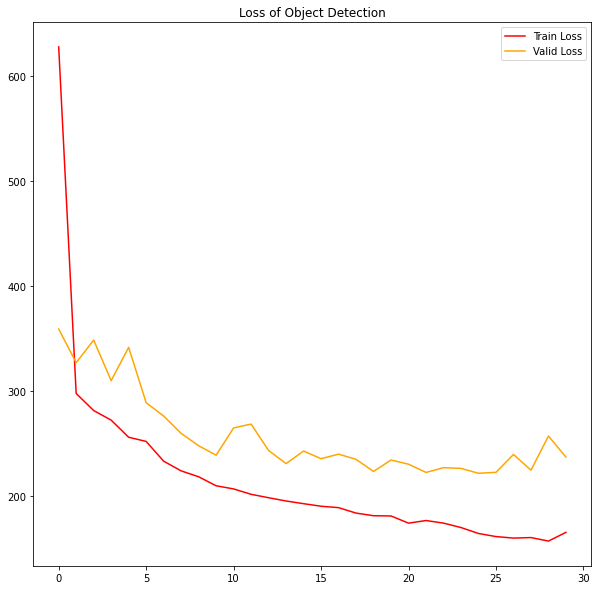

In [ ]:
## Training and Validating and Testing for Face Mask Detection Dataset by Advanced YOLO v3
device = "cuda"
root = os.path.join(os.getcwd(),"drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "model")
anchors = [[(10, 13), (16, 30), (33, 23)], [(30, 61), (62, 45), (59, 119)], [(116, 90), (156, 198), (373, 326)]]

yolov3_actuator = YOLOv3_Actuator(
    root=root,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    model=yolov3,
    opt="adam",
    lr=0.001,
    has_scheduler=True,
    device=device).to(device)

start_time = time.time()
yolov3_actuator.train_and_valid(max_epochs=30, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")
print()


torch.cuda.empty_cache()
for file_name in os.listdir(root):
    if file_name[-4:] == ".pth":
        best_yolo_model = file_name

best_yolo_path = os.path.join(root, best_yolo_model)

yolov3_model = DarkNet(anchors).to(device)
output_cat, output = yolov3_model(sample)
yolov3_model.load_state_dict(torch.load(best_yolo_path))
yolov3_model.eval()

anchors = [[(10, 13), (16, 30), (33, 23)], [(30, 61), (62, 45), (59, 119)], [(116, 90), (156, 198), (373, 326)]]
sample = torch.randn(1, 3, 416, 416).to(device)
with torch.no_grad():
    output_cat, output = yolov3_model(sample)
    print("Output Concetenation Size :", output_cat.size())
    print(output[0].size(), output[1].size(), output[2].size())
    

print("========== YOLOv3 Test ==========")
yolov3_tester = YOLOv3_Actuator(
    root=root,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    model=yolov3_model,
    opt="adam",
    lr=0.001,
    has_scheduler=True,
    device=device).to(device)
yolov3_tester.test()

# <font color="#2F9D27"> **※ Test and Estimate Performance of Advanced YOLO v3** </font>

### <font color="#2F9D27"> **① NMS(Non Maximum Suppression) of Advanced YOLO v3** </font>

In [ ]:
def is_belong(box_a, box_b):
    box_a_xmin = box_a[0] - (box_a[2] / 2)
    box_a_xmax = box_a[0] + (box_a[2] / 2)
    box_a_ymin = box_a[1] - (box_a[3] / 2)
    box_a_ymax = box_a[1] + (box_a[3] / 2)

    box_b_xmin = box_b[0] - (box_b[2] / 2)
    box_b_xmax = box_b[0] + (box_b[2] / 2)
    box_b_ymin = box_b[1] - (box_b[3] / 2)
    box_b_ymax = box_b[1] + (box_b[3] / 2)
    
    if (box_a_xmin < box_b_xmin) and (box_a_ymin < box_b_ymin) and (box_a_xmax > box_b_xmax) and (box_a_ymax > box_b_ymax):
        return True
    elif (box_a_xmin > box_b_xmin) and (box_a_ymin > box_b_ymin) and (box_a_xmax < box_b_xmax) and (box_a_ymax < box_b_ymax):
        return True
    else:
        return False
    

def iou_infer(max_box, comp_box):
    max_box_xmin = max_box[0] - (max_box[2] / 2)
    max_box_xmax = max_box[0] + (max_box[2] / 2)
    max_box_ymin = max_box[1] - (max_box[3] / 2)
    max_box_ymax = max_box[1] + (max_box[3] / 2)

    comp_box_xmin = comp_box[0] - (comp_box[2] / 2)
    comp_box_xmax = comp_box[0] + (comp_box[2] / 2)
    comp_box_ymin = comp_box[1] - (comp_box[3] / 2)
    comp_box_ymax = comp_box[1] + (comp_box[3] / 2)

    xmin = max(max_box_xmin, comp_box_xmin)
    xmax = min(max_box_xmax, comp_box_xmax)
    ymin = max(max_box_ymin, comp_box_ymin)
    ymax = min(max_box_ymin, comp_box_ymax)
    
    area_inter = (xmax - xmin) * (ymax - ymin)
    area_union = (max_box[2] * max_box[3]) + (comp_box[2] * comp_box[3]) - area_inter

    return area_inter / area_union


def nms_infer(output, conf_thres = 0.8, iou_thres = 0.5):
    nms_index = (output[:, 4] > 0.8).nonzero(as_tuple=True)[0]
    output = output[nms_index, :].to('cpu').detach()

    after_nms = []
    bbox_filter = []
    bbox_sort = sorted(output, reverse=True, key=lambda x: x[4])

    for bbox in bbox_sort:
        if bbox[4] > conf_thres:
            bbox_filter.append(bbox)
    
    survive_idx = torch.ones(len(bbox_filter), dtype=torch.bool)
    
    for i in range(len(bbox_filter)):
        for j in range(len(bbox_filter)):
            if i != j :
                iou = iou_infer(bbox_filter[i][:4], bbox_filter[j][:4])
                if (iou > 0.6) or (is_belong(bbox_filter[i][:4], bbox_filter[j][:4]) == True) :
                    if bbox_filter[i][4] >= bbox_filter[j][4]:
                        survive_idx[j] = False
                    else : 
                        survive_idx[i] = False

    if len(bbox_filter) > 0:   
        bbox_filter = torch.stack(bbox_filter, dim=0)
        return bbox_filter[survive_idx, :]
    else:
        return None

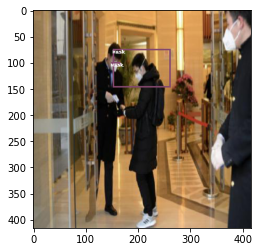

In [ ]:
input_index = 9
img = transforms.functional.to_pil_image(test_data[input_index][0])

output = yolov3_model(test_data[input_index][0].unsqueeze(0).to('cuda'))[0][0]
after_nms = nms_infer(output)

if after_nms != None:
    labels = torch.argmax(after_nms[:, 5:], dim=1)
    boxes = after_nms[:, :4]

width, height = img.size
draw = ImageDraw.Draw(img)

if after_nms != None:

    for label, box in zip(labels, boxes):
        if label == 0:
            name = "Improper Mask"
        elif label == 1:
            name = "Mask"
        elif label == 2:
            name = "No Mask"

        if label <= 2:

            xmin = int(box[0] - box[2]/2)
            ymin = int(box[1] - box[3]/2) 

            xmax = int(box[0] + box[2]/2)
            ymax = int(box[1] + box[3]/2)

            color = [int(c) for c in colors[label]]

            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=tuple(color), width=3)
            draw.text((xmin, ymin), name, fill=(255, 255, 255, 0))
    
plt.imshow(np.array(img))

### <font color="#2F9D27"> **② mAP(mean Average-Precision) of Advanced YOLO v3** </font>

In [ ]:
def meausre_mAP(model, test_data):                                     # mAP 계산을 통한 YOLO v3 정확도 측정
    
    mAP = 0.0

    for i in tqdm(range(len(test_data))):
        
        img = test_data[i][0].unsqueeze(0).to('cuda')
        target = test_data[i][1]
        
        target_labels = target["labels"]
        target_boxes = target["boxes"]
        
        target_bbox_list = torch.cat((target_boxes[target_labels != 3], target_labels[target_labels != 3].unsqueeze(0).T), dim = 1)
        
        output = yolov3_model(img)[0][0]
        after_nms = nms_infer(output)
        
        if after_nms != None:
            labels = torch.argmax(after_nms[:, 5:], dim=1)
            boxes = after_nms[:, :4]
        
            pred_xmin = torch.subtract(boxes[:,0],boxes[:,2]/2).unsqueeze(0).T
            pred_ymin = torch.subtract(boxes[:,1],boxes[:,3]/2).unsqueeze(0).T
            pred_xmax = torch.add(boxes[:,0],boxes[:,2]/2).unsqueeze(0).T
            pred_ymax = torch.add(boxes[:,1],boxes[:,3]/2).unsqueeze(0).T

            pred_bbox_list = torch.cat((pred_xmin, pred_ymin, pred_xmax, pred_ymax), dim = 1)
        
            pred_bbox_list = torch.cat((pred_bbox_list, torch.argmax(after_nms[:,5:], dim=1).unsqueeze(0).T), dim = 1)
            pred_area_list = torch.multiply(boxes[:,2], boxes[:,3])

        AP = 0.0
        if after_nms != None:
            for target_bbox in target_bbox_list:
                xmin, ymin, xmax, ymax = get_coord(target_bbox)

                area = (xmax - xmin) * (ymax - ymin)

                target_xmin = torch.tensor(xmin).repeat(pred_bbox_list.size()[0])
                target_ymin = torch.tensor(ymin).repeat(pred_bbox_list.size()[0])
                target_xmax = torch.tensor(xmax).repeat(pred_bbox_list.size()[0])
                target_ymax = torch.tensor(ymax).repeat(pred_bbox_list.size()[0])

                target_area = torch.tensor(area).repeat(pred_bbox_list.size()[0])
                target_class = target_bbox[4].repeat(pred_bbox_list.size()[0])

                x1_list = torch.maximum(pred_bbox_list[:,0], target_xmin)
                y1_list = torch.maximum(pred_bbox_list[:,1], target_ymin)
                x2_list = torch.minimum(pred_bbox_list[:,2], target_xmax)
                y2_list = torch.minimum(pred_bbox_list[:,3], target_ymax)

                w = torch.maximum(torch.zeros(pred_bbox_list.size()[0]) ,torch.subtract(x2_list, x1_list))
                h = torch.maximum(torch.zeros(pred_bbox_list.size()[0]) ,torch.subtract(y2_list, y1_list))

                intersection_area_list = torch.multiply(w, h)
                union_area_list = torch.subtract(torch.add(target_area, pred_area_list), intersection_area_list)

                iou_list = torch.divide(intersection_area_list, union_area_list)

                iou_treshold = (iou_list >= 0.5)                                # 각 pred bbox가 target bbox와의 IoU가 0.5를 넘어가는지 확인
                is_class_match = (target_class == pred_bbox_list[:,4])          # 각 pred bbox가 예측한 클래스와 target bbox의 클래스가 같은지 확인

                true_count = 0.0
                for idx in range(len(iou_treshold)):
                    if (is_class_match[idx].item() == True) and (iou_treshold[idx].item() == True):
                        true_count +=1.0

                AP += (true_count / len(iou_treshold))
            mAP += AP
    
    mAP = mAP / len(test_data)
        
    return mAP

print(measure_mAP(yolov3_model, test_data))